In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import interactive
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from math import exp
import matplotlib.ticker as ticker

In [2]:
AVD_data = pd.read_csv('raw_data/Adventdalen_Hour.dat', 
	skiprows = [0,2,3],index_col = 0,parse_dates = True, na_values = 'NAN', header = 0 ,
	names = ['TIMESTAMP','RECORD','ID','T2m_PT1000_Max','T2m_PT1000_Min','T2m_PT1000_Avg',
	'T10m_PT1000_Max','T10m_PT1000_Min','T10m_PT1000_Avg',
	'T2m_Rotron_Max','T2m_Rotron_Min','T2m_Rotron_Avg',
	'LF2m_Rotron_Max','LF2m_Rotron_Avg','T10m_Rotron_Max',
	'T10m_Rotron_Min', 'T10m_Rotron_Avg', 'LF10m_Rotron_Max',
	'LF10m_Rotron_Avg','p_mbar','ff2m_mps_Max','ff2m_10min',
	'ff2m_mps_avg', 'dd2m', 'ff10m_sek_Max', 'ff10m_10min',
	'ff10m_mps_Avg','dd10m','Batt_V_Min'])

# Import data from radiation measurements Adventdalen 
AVD_rad_all = pd.read_csv('raw_data/Adventdalen_New_Fem_minutt.dat', 
	skiprows = [0,2,3],index_col = 0, parse_dates = True, na_values = 'NAN',header = 0,
	names = ['TIMESTAMP','RECORD','SWin_Wpm2','LWin_Wpm2','SWout_Wpm2','LWout_Wpm2','CNR1_temp_gr_C_Avg'])

# Radiaton data is available in 5min steps, create hourly mean values of the radiation components. 
# shift(1) - shift the whole dataset by one timestep so that a value at each timestep is the mean of the previous hour
AVD_rad_data = pd.DataFrame.from_dict({
	'SWin_Wpm2':AVD_rad_all['SWin_Wpm2'].resample('H').mean().shift(1), #opp..upward looking instrument measuring SW down
	'SWout_Wpm2': AVD_rad_all['SWout_Wpm2'].resample('H').mean().shift(1), #ned..downward looking instrument measuring SW up
	'LWin_Wpm2': AVD_rad_all['LWin_Wpm2'].resample('H').mean().shift(1),
	'LWout_Wpm2': AVD_rad_all['LWout_Wpm2'].resample('H').mean().shift(1)})
# Import data from AWS Gruvefjellet (GF)
GF_data = pd.read_csv('raw_data/Gruvefjellet_Res_data.dat', 
	skiprows = [0,2,3], index_col = 0,parse_dates = True, na_values = 'NAN', header = 0 ,
	names = ['TIMESTAMP','RECORD','ID','T10cm_minutt_Max','T10cm_minutt_Min','T10cm_minutt_Avg',
	'T1m_minutt_Max','T1m_minutt_Min','T1m_minutt_Avg',
	'T3m_minutt_Max','T3m_minutt_Min','T3m_minutt_Avg',
	'LF_minutt_Max','LF_minutt_Avg','p_mbar','ff_mps_Max','ff_10min',
	'ff_mps_avg', 'dd','NB_time','SD_m','SD_kval','TSS','T_soil_1m',
	'T_soil_2m','T_soil_3m','T_soil_4m','T_soil_5m','T_soil_6m',
	'R_surf_ohm','R_1m_ohm', 'R_2m_ohm', 'R_3m_ohm', 'R_4m_ohm',
	'R_5m_ohm', 'R_6m_ohm', 'Batt_V_Min'])

# Import ERA5 precipitation data
ERA5_all = pd.read_csv('data/ERA5_GF.txt', index_col = 0, parse_dates = True,
	na_values = 'NaN', header = 0, names = ['TIMESTAMP', 'HS', 'RR', 'RRmm',
	'T2m', 'ptype'])
# eklima precipitation data
eklima_LFH_RR_all = pd.read_csv('data/LFH_RR_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['RR','ff'])
eklima_AVD_RR_all = pd.read_csv('data/AVD_RR_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['RR','ff'])
eklima_LFH_T_all = pd.read_csv('data/LFH_T_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['T'])
eklima_AVD_T_all = pd.read_csv('data/AVD_T_ts.txt', index_col=0,parse_dates = True,
na_values='NaN',header=0, names= ['T'])


In [3]:
GF_data = GF_data['2016-08-01 00:00:00':'2017-04-30 23:00:00']			 	
AVD_rad_data = AVD_rad_data['2016-08-01 00:00:00':'2017-04-30 23:00:00'] 
AVD_data = AVD_data['2016-08-01 00:00:00':'2017-04-30 23:00:00']
eklima_LFH_RR = eklima_LFH_RR_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']
eklima_AVD_RR = eklima_AVD_RR_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']
eklima_LFH_T = eklima_LFH_T_all['2016-08-01 00:00:00':'2017-04-30 23:00:00']
eklima_AVD_T = eklima_AVD_T_all['2016-08-01 00:00:00':'2017-04-30 23:00:00']
ERA5 = ERA5_all['2016-08-01 06:00:00':'2017-04-30 23:00:00']

In [4]:
Tdiff_GFAVD_3m2mRot = GF_data.T3m_minutt_Avg - AVD_data.T2m_Rotron_Avg
Tdiff_GFAVD_3m2mPT = GF_data.T3m_minutt_Avg - AVD_data.T2m_PT1000_Avg
Tgrad_GFAVD_3m2mRot = Tdiff_GFAVD_3m2mRot/(464-15)*100
Tgrad_GFAVD_3m2mPT = Tdiff_GFAVD_3m2mPT/(464-15)*100

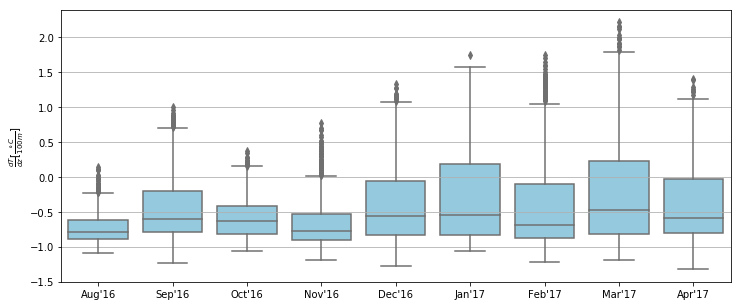

In [5]:

fig1, ax1 = plt.subplots(nrows=1,ncols=1, figsize = (12,5))
ax1.grid()
ax1.set_ylabel(r'$\frac{dT}{dz} [\frac{\circ C}{100 m}]$')
sns.boxplot(Tgrad_GFAVD_3m2mPT.index.strftime("%b\'%y"),Tgrad_GFAVD_3m2mPT,ax=ax1,
 color='skyblue', saturation=0.75)
plt.savefig('./figures/boxpl_TgradGFAVD3m2mPT.eps')
plt.savefig('./figures/boxpl_TgradGFAVD3m2mPT.png')

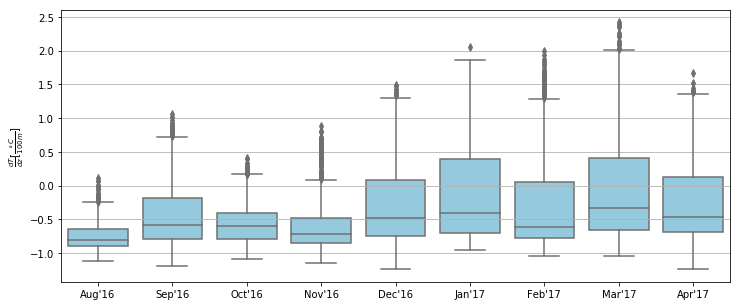

In [6]:
fig2, ax2 = plt.subplots(nrows=1,ncols=1, figsize = (12,5))
ax2.grid()
ax2.set_ylabel(r'$\frac{dT}{dz} [\frac{\circ C}{100 m}]$')
sns.boxplot(Tgrad_GFAVD_3m2mRot.index.strftime("%b\'%y"),Tgrad_GFAVD_3m2mRot,ax=ax2,
 color='skyblue', saturation=0.75)
plt.savefig('./figures/boxpl_TgradGFAVD3m2mRot.eps')
plt.savefig('./figures/boxpl_TgradGFAVD3m2mRot.png')

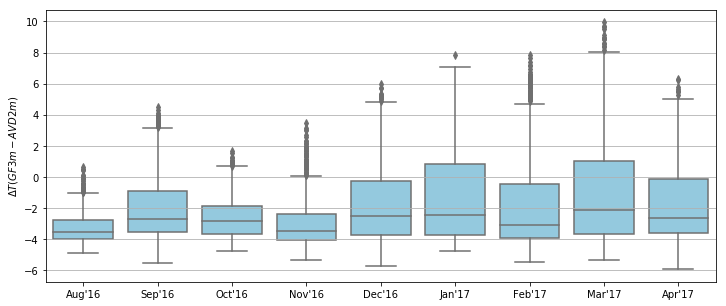

In [7]:
fig3, ax3 = plt.subplots(nrows=1,ncols=1, figsize = (12,5))
ax3.grid()
ax3.set_ylabel(r'$\Delta T (GF3m - AVD2m)$')
sns.boxplot(Tdiff_GFAVD_3m2mPT.index.strftime("%b\'%y"),Tdiff_GFAVD_3m2mPT,ax=ax3,
 color='skyblue', saturation=0.75)
plt.savefig('./figures/boxpl_TdiffGFAVD3m2mPT.eps')
plt.savefig('./figures/boxpl_TdiffGFAVD3m2mPT.png')

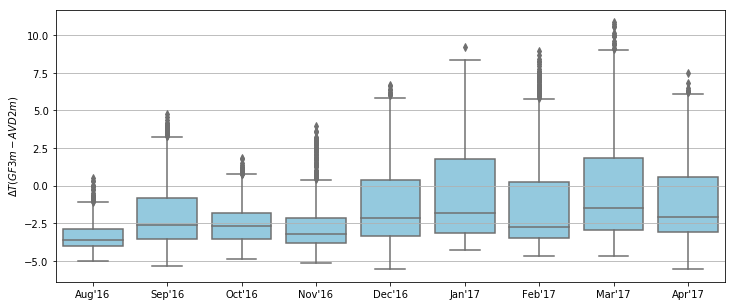

In [8]:
fig4, ax4 = plt.subplots(nrows=1,ncols=1, figsize = (12,5))
ax4.grid()
ax4.set_ylabel(r'$\Delta T (GF3m - AVD2m)$')
sns.boxplot(Tdiff_GFAVD_3m2mRot.index.strftime("%b\'%y"),Tdiff_GFAVD_3m2mRot,ax=ax4,
 color='skyblue', saturation=0.75)
plt.savefig('./figures/boxpl_TdiffGFAVD3m2mRot.eps')
plt.savefig('./figures/boxpl_TdiffGFAVD3m2mRot.png')

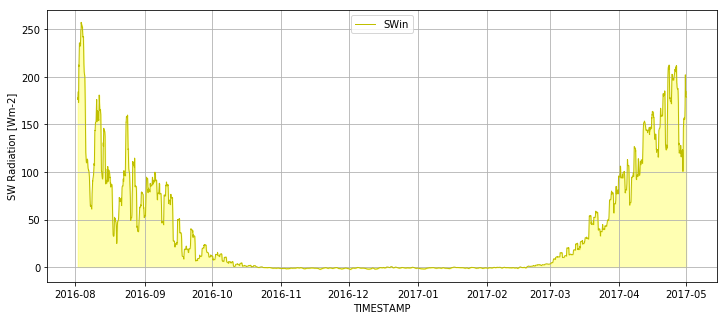

In [9]:
f5, ax5 = plt.subplots(nrows = 1, ncols=1, figsize= (12,5))
ax5.grid()
sns.lineplot(AVD_rad_data.index, AVD_rad_data.SWin_Wpm2.rolling(window=24).mean(), color = 'y', linewidth = 1, label = 'SWin')
line = ax5.lines[0]
x=line.get_xydata()[:,0]
y=line.get_xydata()[:,1]
ax5.fill_between(x,y,color="yellow", alpha = 0.3)
ax5.set_ylabel('SW Radiation [Wm-2]')
ax5.legend(loc = 'upper center')
plt.savefig('./figures/timeline_ISWR_AVD.png')
plt.savefig('./figures/timeline_ISWR_AVD.eps')


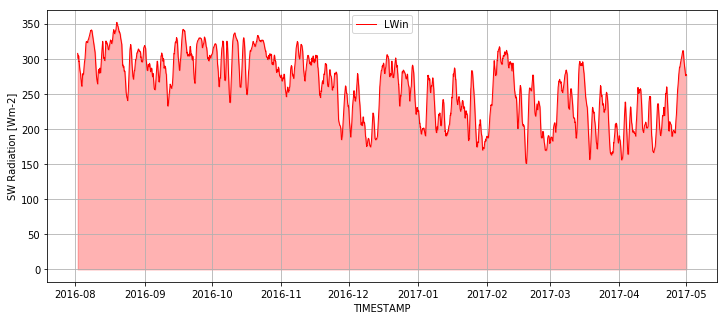

In [10]:
f6, ax6 = plt.subplots(nrows = 1, ncols=1, figsize= (12,5))
ax6.grid()
sns.lineplot(AVD_rad_data.index, AVD_rad_data.LWin_Wpm2.rolling(window=24).mean(), color = 'r', linewidth = 1, label = 'LWin')
line1 = ax6.lines[0]
x=line1.get_xydata()[:,0]
y=line1.get_xydata()[:,1]
ax6.fill_between(x,y,color="red", alpha = 0.3)
ax6.set_ylabel('SW Radiation [Wm-2]')
ax6.legend(loc = 'upper center')
plt.savefig('./figures/timeline_ILWR_AVD.png')
plt.savefig('./figures/timeline_ILWR_AVD.eps')

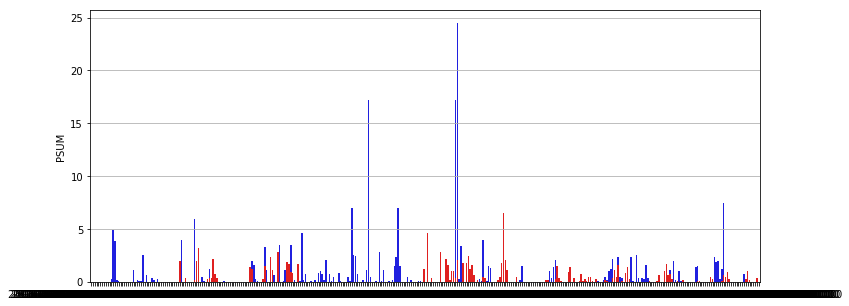

In [11]:
firstofmonth = mdates.DayLocator(bymonthday=1)
f7, ax7 = plt.subplots(nrows = 1, ncols=1, figsize= (12,5))
ax7.grid()
sns.barplot(x = eklima_LFH_RR.index, y = eklima_LFH_RR.RR ,data=eklima_LFH_RR, color = 'b')
sns.barplot(x = eklima_AVD_RR.index, y = eklima_AVD_RR.RR, data=eklima_AVD_RR, color = 'r' )
#ax7.xaxis.set_major_locator(firstofmonth)
ax7.set_ylabel('PSUM')
# plt.savefig('./figures/timeline_ISWR_AVD.png')
# plt.savefig('./figures/timeline_ISWR_AVD.eps')
plt.show(f7)

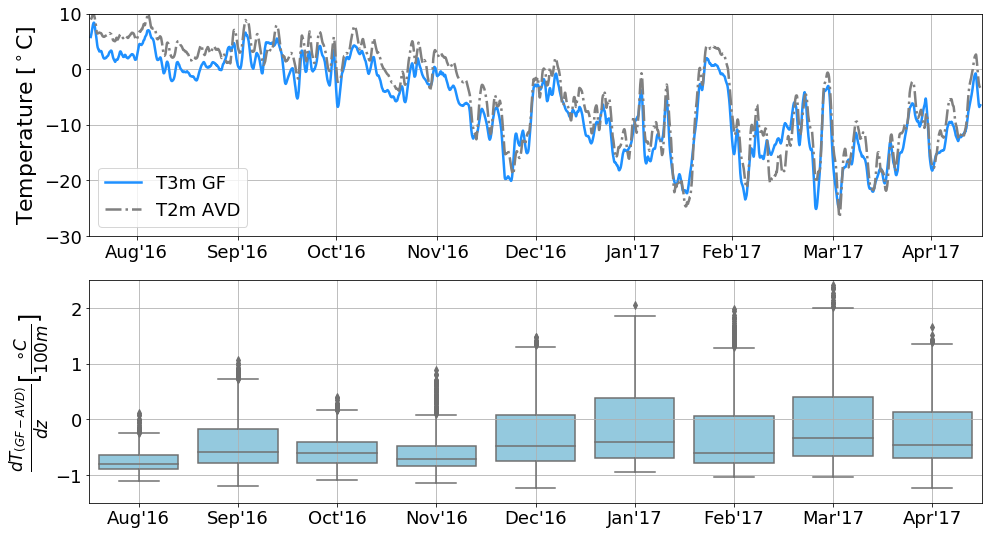

In [15]:
f9, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))
maxGF = max(GF_data.T3m_minutt_Avg)
maxAVD = max(AVD_data.T2m_PT1000_Avg)

dTind = GF_data.index
xticks=[]
dates = ['2016-08-15 12:00:00','2016-09-15 12:00:00','2016-10-15 12:00:00','2016-11-15 12:00:00','2016-12-15 12:00:00',
        '2017-01-14 12:00:00','2017-02-13 12:00:00','2017-03-16 12:00:00','2017-04-15 12:00:00',]
for counter, value in enumerate(dTind):
    if str(value) in dates:
        xticks.append(counter)

ax1.grid()
data = pd.DataFrame.from_records({"GF":GF_data.T3m_minutt_Avg.tolist(),'AVD':AVD_data.T2m_PT1000_Avg.tolist()})
ax1.plot(data.index, data.GF.rolling(24,center=True).mean(),color="#1E90FF",linestyle='-',linewidth=2.5, label = "T3m GF")
ax1.plot(data.index, data.AVD.rolling(24,center=True).mean(),color ="#808080",linestyle='-.', linewidth=2.5, label = "T2m AVD")
ax1.set_ylabel("Temperature [$^\circ$C]",fontsize =22)
ax1.set_ylim((-30,10))
ax1.set_xlim((0,len(data.index)))
ax1.set_xticks(ticks=xticks)
# ax1.set_xticklabels(['2016-08-01','2016-09-01','2016-10-01','2016-11-01','2016-12-01',
#         '2017-01-01','2017-02-01','2017-03-01','2017-04-01'])
ax1.set_xticklabels(['Aug\'16','Sep\'16','Oct\'16','Nov\'16','Dec\'16',
        'Jan\'17','Feb\'17','Mar\'17','Apr\'17'])
ax1.tick_params(labelsize=18)
ax1.legend(fontsize=18)
# ax1.plot(GF_data.index, GF_data.T3m_minutt_Avg.rolling("24h").mean(),color="#1E90FF",linestyle='-',linewidth=2.5, label = "T3m GF")
# ax1.plot(AVD_data.index, AVD_data.T2m_PT1000_Avg.rolling("24h").mean(),color ="#808080",linestyle='-.', linewidth=2.5, label = "T2m AVD")
# ax1.set_ylabel("Temperature [$^\circ$C]",fontsize =22)
# ax1.set_ylim((-30,10))
# ax1.set_xlim([dt.date(2016,8,1),dt.date(2017,4,30)])
# ax1.legend(fontsize=18)
# ax1.xaxis.set_major_locator(mdates.MonthLocator())
# ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
# ax1.xaxis.set_major_formatter(ticker.NullFormatter())
# ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b\'%y"))
# for tick in ax1.xaxis.get_minor_ticks():
#     tick.label.set_fontsize(18)
    

sns.boxplot(Tgrad_GFAVD_3m2mRot.index.strftime("%b\'%y"),Tgrad_GFAVD_3m2mRot,ax=ax2,
 color='skyblue', saturation=0.75)
ax2.set_ylabel(r'$\frac{dT_{(GF-AVD)}}{dz} [\frac{\circ C}{100 m}]$', fontsize=24)
ax2.tick_params(labelsize=18)
ax2.set_ylim([-1.5,2.5])
ax2.grid()
# print(Tgrad_GFAVD_3m2mPT.median())
plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.png')
plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.eps')




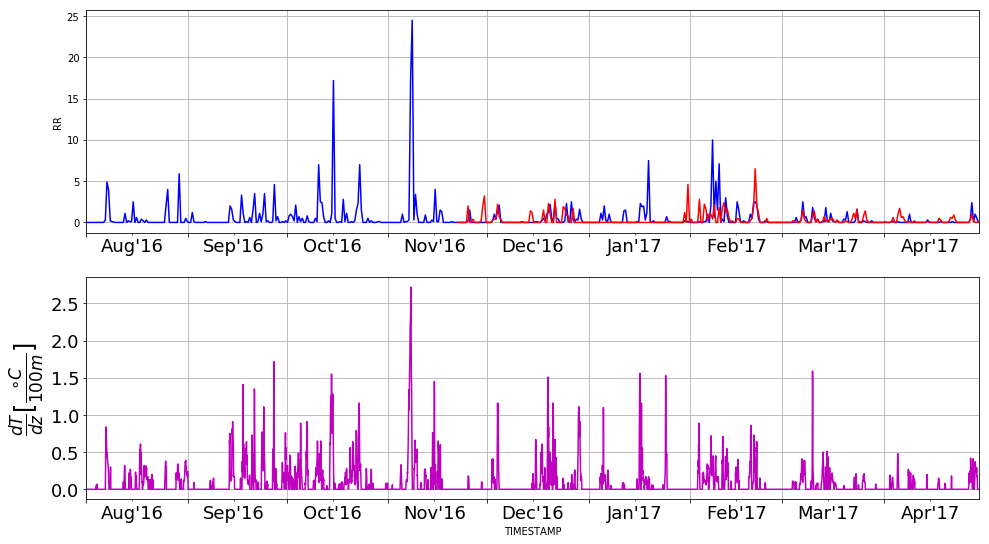

In [13]:
f9, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))
ax1.grid()
sns.lineplot(x = eklima_LFH_RR.index, y = eklima_LFH_RR.RR ,data=eklima_LFH_RR, color = 'b', ax = ax1)
sns.lineplot(x = eklima_AVD_RR.index, y = eklima_AVD_RR.RR, data=eklima_AVD_RR, color = 'r', ax = ax1 )
#ax1.set_ylabel("Temperature [$^\circ$C]",fontsize =22)
#ax1.set_ylim((-30,10))
ax1.set_xlim([dt.date(2016,8,1),dt.date(2017,4,30)])
# ax1.xaxis.set_major_locator(firstofmonth)
#ax1.legend(fontsize=18)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b\'%y"))
for tick in ax1.xaxis.get_minor_ticks():
   tick.label.set_fontsize(18)
    
ax2.grid()
sns.lineplot(x = ERA5.index, y = ERA5.RRmm, data=ERA5, color ='m',ax=ax2)
ax2.set_ylabel(r'$\frac{dT}{dz} [\frac{\circ C}{100 m}]$', fontsize=24)
ax2.tick_params(labelsize=18)
ax2.set_xlim([dt.date(2016,8,1),dt.date(2017,4,30)])
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b\'%y"))
for tick in ax2.xaxis.get_minor_ticks():
   tick.label.set_fontsize(18)
#print(Tgrad_GFAVD_3m2mPT.median())
#plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.png')
#plt.savefig('./figures/timel_T3mGF_T2mAVD_with_boxpl_Tgrad.eps')

DatetimeIndex(['2016-08-01 06:00:00', '2016-08-01 18:00:00',
               '2016-08-02 06:00:00', '2016-08-02 18:00:00',
               '2016-08-03 06:00:00', '2016-08-03 18:00:00',
               '2016-08-04 06:00:00', '2016-08-04 18:00:00',
               '2016-08-05 06:00:00', '2016-08-05 18:00:00',
               ...
               '2017-04-25 06:00:00', '2017-04-25 18:00:00',
               '2017-04-26 06:00:00', '2017-04-26 18:00:00',
               '2017-04-27 06:00:00', '2017-04-27 18:00:00',
               '2017-04-28 06:00:00', '2017-04-28 18:00:00',
               '2017-04-29 06:00:00', '2017-04-29 18:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=544, freq='12H')


(736177.0, 736449.0)

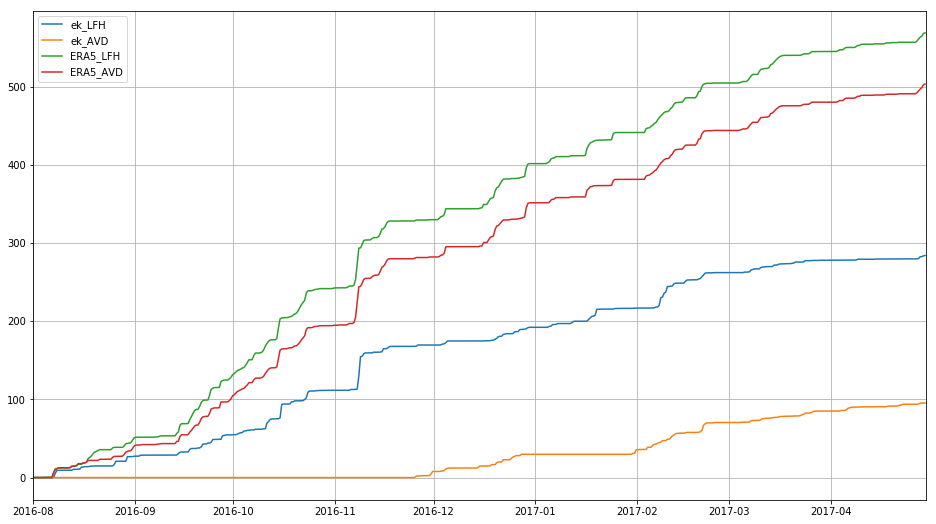

In [14]:
# firstofmonth = mdates.DayLocator(bymonthday=1)

ek_LFH = pd.read_csv('data/LFH_RR_ts.txt', na_values = 'NaN')
ek_LFH.DateTime = pd.to_datetime(ek_LFH.DateTime)
ek_LFH.set_index('DateTime',inplace=True)

ek_AVD = pd.read_csv('data/AVD_RR_ts.txt', na_values = 'NaN')
ek_AVD.DateTime = pd.to_datetime(ek_AVD.DateTime)
ek_AVD.set_index('DateTime',inplace=True)

ERA5_RR1h_LFH = pd.read_csv('data/ERA5_GF.txt', na_values = 'NaN')
ERA5_RR1h_LFH['DateTime'] = pd.to_datetime(ERA5_RR1h_LFH['DateTime'])
ERA5_RR1h_LFH.set_index('DateTime',inplace=True)

ERA5_RR1h_AVD = pd.read_csv('data/ERA5_AVD.txt', na_values = 'NaN')
ERA5_RR1h_AVD['DateTime'] = pd.to_datetime(ERA5_RR1h_AVD['DateTime'])
ERA5_RR1h_AVD.set_index('DateTime',inplace=True)


ERA5_RR12h_LFH = ERA5_RR1h_LFH.RRmm.resample('12H', base = 6).sum()
ERA5_RR12h_LFH = ERA5_RR12h_LFH['2016-08-01 00:00:00':'2017-04-30 0:00:00']

ERA5_RR12h_AVD = ERA5_RR1h_AVD.RRmm.resample('12H', base = 6).sum()
ERA5_RR12h_AVD = ERA5_RR12h_AVD['2016-08-01 00:00:00':'2017-04-30 00:00:00']
ek_LFH = ek_LFH['2016-08-01 00:00:00':'2017-04-30 00:00:00']
ek_AVD = ek_AVD['2016-08-01 00:00:00':'2017-04-30 00:00:00']


precip = pd.DataFrame()
precip['ERA5_12H_LFH'] = ERA5_RR12h_LFH
precip['ERA5_12H_AVD'] = ERA5_RR12h_AVD
precip['ek_LFH'] = ek_LFH.RR
precip['ek_AVD'] = ek_AVD.RR

print(precip.index)

plt.figure(figsize = (16,9))
ns_ek_LFH = precip['ek_LFH'].tolist()
ns_sum_ekLFH = [np.nansum(ns_ek_LFH[0:i]) for i in range(len(ns_ek_LFH))]
plt.plot(precip.index, ns_sum_ekLFH,label = 'ek_LFH')

ns_ek_AVD = precip['ek_AVD'].tolist()
ns_sum_ekAVD = [np.nansum(ns_ek_AVD[0:i]) for i in range(len(ns_ek_AVD))]
plt.plot(precip.index, ns_sum_ekAVD,label = 'ek_AVD')

ns_ERA5_LFH = precip['ERA5_12H_LFH'].tolist()
ns_sum_ERALFH = [np.nansum(ns_ERA5_LFH[0:i]) for i in range(len(ns_ERA5_LFH))]
plt.plot(precip.index, ns_sum_ERALFH,label = 'ERA5_LFH')

ns_ERA5_AVD = precip['ERA5_12H_AVD'].tolist()
ns_sum_ERA5AVD = [np.nansum(ns_ERA5_AVD[0:i]) for i in range(len(ns_ERA5_AVD))]
plt.plot(precip.index, ns_sum_ERA5AVD,label = 'ERA5_AVD')
plt.legend()
plt.grid(which='major')
plt.xlim([dt.date(2016,8,1),dt.date(2017,4,30)])

# f, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))

# precip.plot.bar(ax = ax1)
# ax1.grid()
# ax1.tick_params(labelsize=18)
# ax1.xaxis_date()
# # ax1.set_ylim([0,])
# # ax.set_xlim([dt.date(2016,8,1),dt.date(2017,4,30)])
# ax1.xaxis.set_major_locator(mdates.MonthLocator())
# ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
# ax1.xaxis.set_major_formatter(ticker.NullFormatter())
# ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b\'%y"))
# for tick in ax1.xaxis.get_minor_ticks():
#     tick.label.set_fontsize(18)
    
    

# precip.plot.line(ax=ax2)
# ax2.grid()
# ax2.tick_params(labelsize=18)
# ax2.xaxis_date()
# # ax2.set_ylim([0,12])
# # ax2.set_xlim([dt.date(2016,8,1),dt.date(2017,4,30)])
# ax2.xaxis.set_major_locator(mdates.MonthLocator())
# ax2.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
# ax2.xaxis.set_major_formatter(ticker.NullFormatter())
# ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b\'%y"))
# for tick in ax2.xaxis.get_minor_ticks():
#    tick.label.set_fontsize(18)
    


# fig, ax = plt.subplots(figsize=(16,9))

# # ax.bar(precip.index, precip['ERA5_12H_LFH'])
# # ax.bar(precip.index, precip['ERA5_12H_AVD'])
# # ax.bar(precip.index, precip['ek_LFH'])
# # ax.bar(precip.index, precip['ek_AVD'])

# precip.plot.bar(ax = ax)
# ax.grid()
# ax.tick_params(labelsize=18)
# ax.xaxis_date()
# ax.set_ylim([0,12])
# # ax.set_xlim([dt.date(2016,8,1),dt.date(2017,4,30)])
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
# ax.xaxis.set_major_formatter(ticker.NullFormatter())
# ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b\'%y"))
# for tick in ax.xaxis.get_minor_ticks():
#     tick.label.set_fontsize(18)


